In [59]:
import torch
TRAIN_IMG_SIZE = (480, 640, 3)
VAL_IMG_SIZE = TRAIN_IMG_SIZE
TEST_IMG_SIZE = TRAIN_IMG_SIZE
N_CLASSES = 12
TRAIN_BATCH_SIZE = 8
VAL_BATCH_SIZE = 8
TEST_BATCH_SIZE = 4
NUM_EPOCHS = 40
TRAIN_NUM_WORKERS = 2
VAL_NUM_WORKERS = 2
TEST_NUM_WORKERS = 2
PIN_MEMORY = True
LEARNING_RATE = 0.001
TRAIN_NUM_WORKERS = 2
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

LOAD_MODEL = False
START_EPOCH = 1
DATA_DIR ='../input/rescuenet/RescueNet'
print(DEVICE)

cuda


In [60]:
!pip install segmentation-models-pytorch
!pip install torchsummary
!pip install timm

import segmentation_models_pytorch.utils


# ****Install Libraries****

In [61]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import albumentations as albu
import cv2
from albumentations.pytorch import ToTensorV2
from tqdm import tqdm


from torch.utils.data import Dataset, DataLoader

import segmentation_models_pytorch as smp
import torchsummary as summary

torch.set_default_dtype(torch.float32)

torch.backends.cudnn.benchmark = True

# ****Load Data****

In [62]:
def get_dir(subPath):  
    image_dir = os.path.join(DATA_DIR, subPath, subPath+"-org-img/" )
    label_dir = os.path.join(DATA_DIR, subPath, subPath+"-label-img/" )
    return [image_dir, label_dir]

In [63]:
x_train_dir, y_train_dir = get_dir('train')
x_val_dir, y_val_dir = get_dir('val')
x_test_dir, y_test_dir = get_dir('test')

In [64]:
def listFiles(subPath):
    org_dir, label_dir = get_dir(subPath)
    df = pd.DataFrame(columns=['folder_path','image_name', 'extension'])

    for img in os.listdir(org_dir):
        info = {
            'folder_path': [org_dir], 
            'image_name': [img[0:5]], 
            'extension': ['jpg']}
        info_ = pd.DataFrame(data=info)
        df = pd.concat((df, info_))

    df = df.drop_duplicates(subset=['image_name'])

    imgs = df.iloc[:,0] + df.iloc[:,1] + '.jpg'
    imgs = imgs.reset_index(drop=True)
    labels = label_dir + df.iloc[:,1] + '_lab.png'
    labels = labels.reset_index(drop=True)

    df = pd.concat((imgs,labels),axis=1)
    return df

In [65]:
train_df = listFiles('train')
val_df = listFiles('val')
test_df = listFiles('test')
train_df.iloc[:, 1].values

array(['../input/rescuenet/RescueNet/train/train-label-img/13288_lab.png',
       '../input/rescuenet/RescueNet/train/train-label-img/11925_lab.png',
       '../input/rescuenet/RescueNet/train/train-label-img/11378_lab.png',
       ...,
       '../input/rescuenet/RescueNet/train/train-label-img/13877_lab.png',
       '../input/rescuenet/RescueNet/train/train-label-img/11205_lab.png',
       '../input/rescuenet/RescueNet/train/train-label-img/11590_lab.png'],
      dtype=object)

In [66]:
print('train set size:',len(train_df))
print('val set size:',len(val_df))
print('test set size:',len(test_df))

train set size: 3595
val set size: 449
test set size: 450


In [67]:
len(train_df.iloc[:, 1]) == len(train_df.iloc[:,0])

True

In [68]:
class RescueNetDataset(Dataset):
    def __init__(self, df, transforms):
        super(RescueNetDataset, self).__init__()
        self.df = df
        self.transforms = transforms

    def __len__(self):
        return len(self.df)

    def __getitem__(self, index):
        img_path, mask_path = self.df.loc[index]
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        mask = cv2.imread(mask_path, cv2.IMREAD_UNCHANGED)
        
        transformed = self.transforms(image=img, mask=mask)
        img = transformed['image']
        mask = transformed['mask']
        
        
        img = img/255
        img = img.astype('float32')

        img = np.transpose(img, (2,0,1))
        
        mask_stacked = np.array([mask==0])
        for i in range(1, 12):
            mask_stacked = np.concatenate([mask_stacked, np.array([mask==i])])
        mask = mask_stacked.astype(int)
        mask = mask.astype('int64')
        
        img = torch.from_numpy(img)
        mask = torch.from_numpy(mask)
        
        return img, mask


train_transforms = albu.Compose([
    albu.RandomScale(scale_limit=0.1),
    albu.Flip(),
    albu.Rotate(limit=30),
    albu.Resize(TRAIN_IMG_SIZE[0], TRAIN_IMG_SIZE[1]),
])

val_transforms = albu.Compose([
    albu.Resize(VAL_IMG_SIZE[0], VAL_IMG_SIZE[1]),
])

test_transforms = albu.Compose([
    albu.Resize(TEST_IMG_SIZE[0], TEST_IMG_SIZE[1]),
])

train_dataset = RescueNetDataset(df=train_df, transforms=train_transforms)
val_dataset = RescueNetDataset(df=val_df, transforms=val_transforms)
test_dataset = RescueNetDataset(df=test_df, transforms=test_transforms)

train_loader = DataLoader(
    dataset=train_dataset,
    batch_size=TRAIN_BATCH_SIZE,
    shuffle=True,
    num_workers=TRAIN_NUM_WORKERS,
    pin_memory=PIN_MEMORY,
    drop_last=True
)

val_loader = DataLoader(
    dataset=val_dataset,
    batch_size=VAL_BATCH_SIZE,
    shuffle=False,
    num_workers=VAL_NUM_WORKERS,
    pin_memory=PIN_MEMORY,
    drop_last=True,
)

test_loader = DataLoader(
    dataset=test_dataset,
    batch_size=TEST_BATCH_SIZE,
    shuffle=False,
    num_workers=TEST_NUM_WORKERS,
    pin_memory=PIN_MEMORY,
    drop_last=True,
)

torch.Size([8, 3, 480, 640]) torch.Size([8, 12, 480, 640])
torch.float32


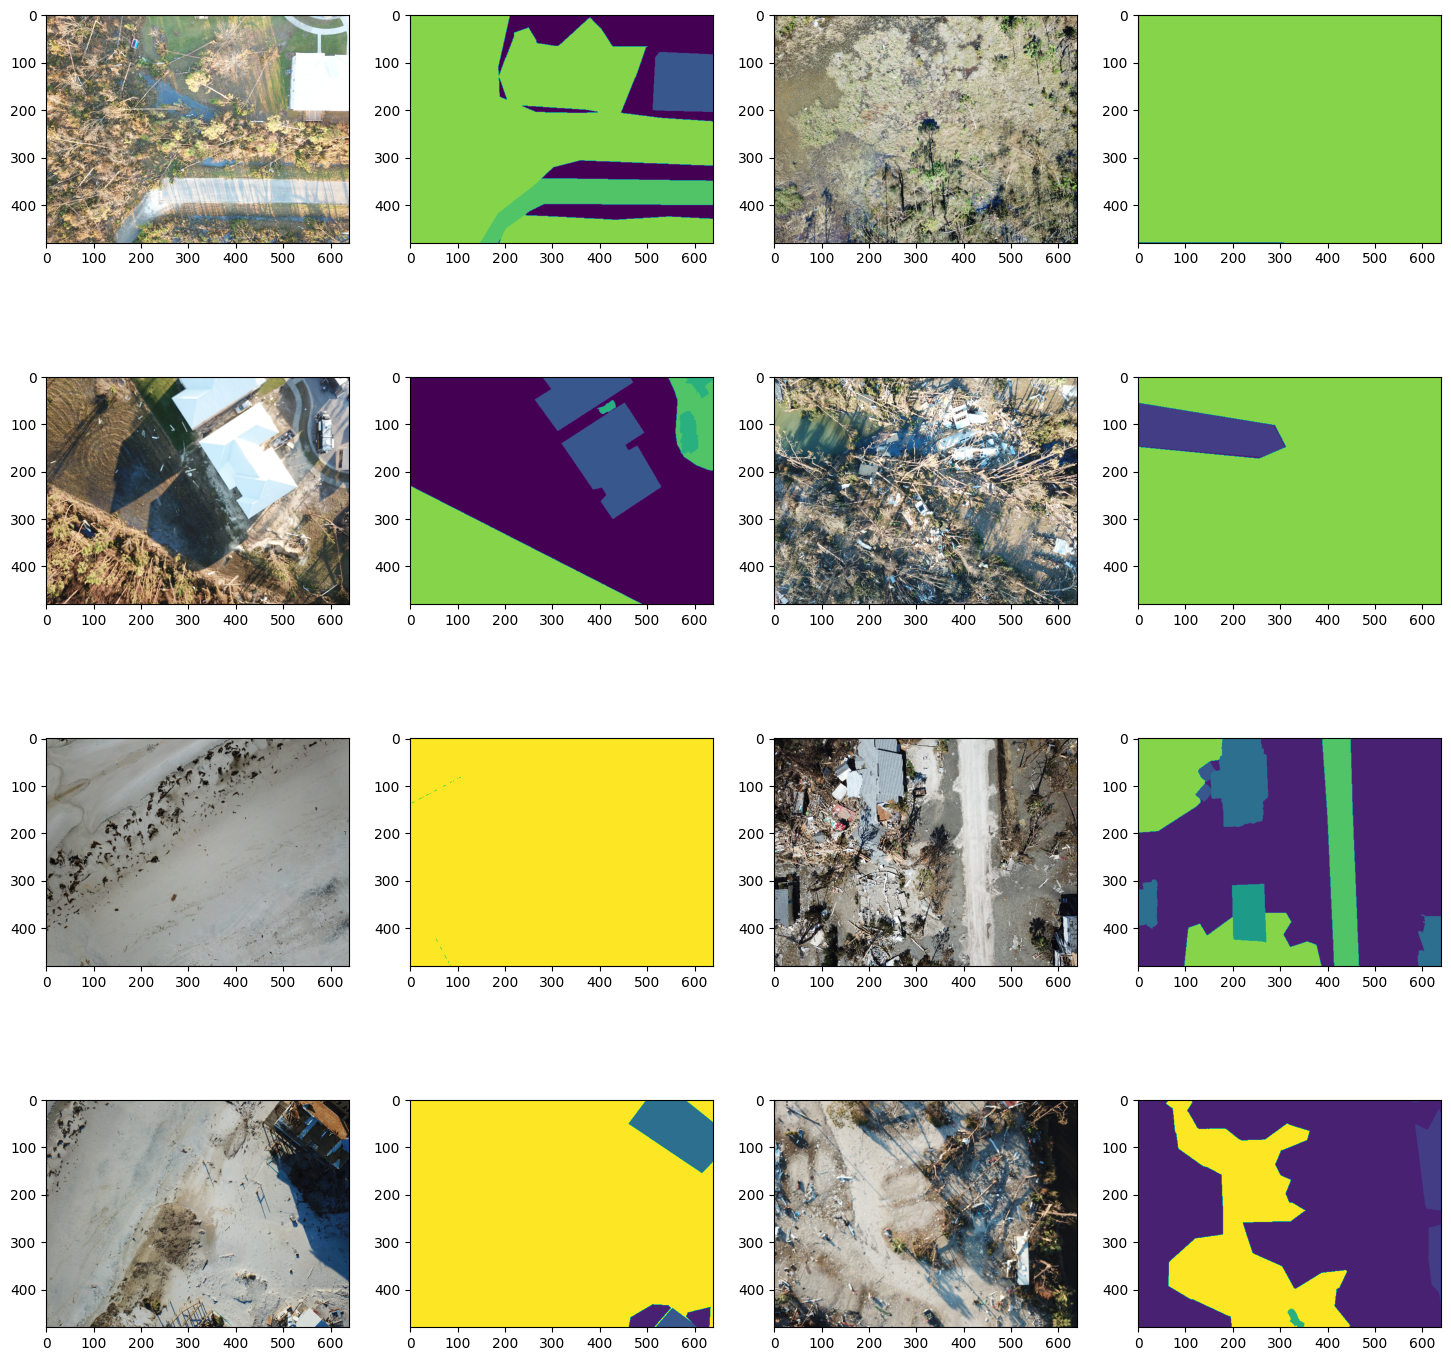

In [69]:
iterator = iter(train_loader)
imgs, masks = next(iterator)
print(imgs.shape, masks.shape)
print(imgs.dtype)

fig, axs = plt.subplots(nrows=4, ncols=4,figsize=(18,18))

count = 0
for r in range(4):
    axs[r,0].imshow(imgs[count].permute(1,2,0))
    axs[r,1].imshow(np.argmax(masks[count], axis=0), vmin=0, vmax=11)
    count += 1
    axs[r,2].imshow(imgs[count].permute(1,2,0))
    axs[r,3].imshow(np.argmax(masks[count], axis=0), vmin=0, vmax=11)
    count += 1

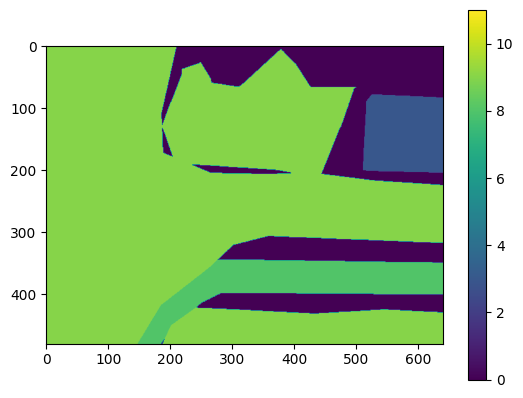

In [70]:
plt.imshow(np.argmax(masks[0], axis=0), vmin=0, vmax=11)
plt.colorbar()

# ****Define Model****

In [71]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from timm.models.layers import trunc_normal_, DropPath
from timm.models.registry import register_model


class Block(nn.Module):
    r""" ConvNeXt Block. There are two equivalent implementations:
    (1) DwConv -> LayerNorm (channels_first) -> 1x1 Conv -> GELU -> 1x1 Conv; all in (N, C, H, W)
    (2) DwConv -> Permute to (N, H, W, C); LayerNorm (channels_last) -> Linear -> GELU -> Linear; Permute back
    We use (2) as we find it slightly faster in PyTorch

    Args:
        dim (int): Number of input channels.
        drop_path (float): Stochastic depth rate. Default: 0.0
        layer_scale_init_value (float): Init value for Layer Scale. Default: 1e-6.
    """

    def __init__(self, dim, drop_path=0., layer_scale_init_value=1e-6):
        super().__init__()
        self.dwconv = nn.Conv2d(dim, dim, kernel_size=7, padding=3, groups=dim)  # depthwise conv
        self.norm = LayerNorm(dim, eps=1e-6)
        self.pwconv1 = nn.Linear(dim, 4 * dim)  # pointwise/1x1 convs, implemented with linear layers
        self.act = nn.GELU()
        self.pwconv2 = nn.Linear(4 * dim, dim)
        self.gamma = nn.Parameter(layer_scale_init_value * torch.ones((dim)),
                                  requires_grad=True) if layer_scale_init_value > 0 else None
        self.drop_path = DropPath(drop_path) if drop_path > 0. else nn.Identity()

    def forward(self, x):
        input = x
        x = self.dwconv(x)
        x = x.permute(0, 2, 3, 1)  # (N, C, H, W) -> (N, H, W, C)
        x = self.norm(x)
        x = self.pwconv1(x)
        x = self.act(x)
        x = self.pwconv2(x)
        if self.gamma is not None:
            x = self.gamma * x
        x = x.permute(0, 3, 1, 2)  # (N, H, W, C) -> (N, C, H, W)

        x = input + self.drop_path(x)
        return x


class ConvNeXt(nn.Module):
    r""" ConvNeXt
        A PyTorch impl of : `A ConvNet for the 2020s`  -
          https://arxiv.org/pdf/2201.03545.pdf

    Args:
        in_chans (int): Number of input image channels. Default: 3
        num_classes (int): Number of classes for classification head. Default: 1000
        depths (tuple(int)): Number of blocks at each stage. Default: [3, 3, 9, 3]
        dims (int): Feature dimension at each stage. Default: [96, 192, 384, 768]
        drop_path_rate (float): Stochastic depth rate. Default: 0.
        layer_scale_init_value (float): Init value for Layer Scale. Default: 1e-6.
        head_init_scale (float): Init scaling value for classifier weights and biases. Default: 1.
    """

    def __init__(self, in_chans=3, num_classes=1000, to_cls=False,
                 depths=[3, 3, 9, 3], dims=[96, 192, 384, 768], drop_path_rate=0.,
                 layer_scale_init_value=1e-6, head_init_scale=1.):
        super().__init__()
        self.dims = dims
        self.to_cls = to_cls

        self.downsample_layers = nn.ModuleList()  # stem and 3 intermediate downsampling conv layers
        stem = nn.Sequential(
            nn.Conv2d(in_chans, dims[0], kernel_size=4, stride=4),
            LayerNorm(dims[0], eps=1e-6, data_format="channels_first")
        )
        self.downsample_layers.append(stem)
        for i in range(3):
            downsample_layer = nn.Sequential(
                LayerNorm(dims[i], eps=1e-6, data_format="channels_first"),
                nn.Conv2d(dims[i], dims[i + 1], kernel_size=2, stride=2),
            )
            self.downsample_layers.append(downsample_layer)

        self.stages = nn.ModuleList()  # 4 feature resolution stages, each consisting of multiple residual blocks
        dp_rates = [x.item() for x in torch.linspace(0, drop_path_rate, sum(depths))]
        cur = 0
        for i in range(4):
            stage = nn.Sequential(
                *[Block(dim=dims[i], drop_path=dp_rates[cur + j],
                        layer_scale_init_value=layer_scale_init_value) for j in range(depths[i])]
            )
            self.stages.append(stage)
            cur += depths[i]

        self.norm = nn.LayerNorm(dims[-1], eps=1e-6)  # final norm layer
        self.head = nn.Linear(dims[-1], num_classes)

        self.apply(self._init_weights)
        self.head.weight.data.mul_(head_init_scale)
        self.head.bias.data.mul_(head_init_scale)

    def _init_weights(self, m):
        if isinstance(m, (nn.Conv2d, nn.Linear)):
            trunc_normal_(m.weight, std=.02)
            nn.init.constant_(m.bias, 0)

    def forward_features(self, x):
        for i in range(4):
            x = self.downsample_layers[i](x)
            x = self.stages[i](x)
        return self.norm(x.mean([-2, -1]))  # global average pooling, (N, C, H, W) -> (N, C)

    def forward(self, x):
        _, C, H, W = x.shape
        features = []
        for i in range(4):
            x = self.downsample_layers[i](x)
            x = self.stages[i](x)
            features.append(x)
        if not self.to_cls:
            return features
        else:
            x = self.head(self.norm(x.mean([-2,-1])))
            return x

    # def forward(self, x):
    #     x = self.forward_features(x)
    #     x = self.head(x)
    #     return x


class LayerNorm(nn.Module):
    r""" LayerNorm that supports two data formats: channels_last (default) or channels_first.
    The ordering of the dimensions in the inputs. channels_last corresponds to inputs with
    shape (batch_size, height, width, channels) while channels_first corresponds to inputs
    with shape (batch_size, channels, height, width).
    """

    def __init__(self, normalized_shape, eps=1e-6, data_format="channels_last"):
        super().__init__()
        self.weight = nn.Parameter(torch.ones(normalized_shape))
        self.bias = nn.Parameter(torch.zeros(normalized_shape))
        self.eps = eps
        self.data_format = data_format
        if self.data_format not in ["channels_last", "channels_first"]:
            raise NotImplementedError
        self.normalized_shape = (normalized_shape,)

    def forward(self, x):
        if self.data_format == "channels_last":
            return F.layer_norm(x, self.normalized_shape, self.weight, self.bias, self.eps)
        elif self.data_format == "channels_first":
            u = x.mean(1, keepdim=True)
            s = (x - u).pow(2).mean(1, keepdim=True)
            x = (x - u) / torch.sqrt(s + self.eps)
            x = self.weight[:, None, None] * x + self.bias[:, None, None]
            return x


model_urls = {
    "convnext_tiny_1k": "https://dl.fbaipublicfiles.com/convnext/convnext_tiny_1k_224_ema.pth",
    "convnext_small_1k": "https://dl.fbaipublicfiles.com/convnext/convnext_small_1k_224_ema.pth",
    "convnext_base_1k": "https://dl.fbaipublicfiles.com/convnext/convnext_base_1k_224_ema.pth",
    "convnext_large_1k": "https://dl.fbaipublicfiles.com/convnext/convnext_large_1k_224_ema.pth",
    "convnext_base_22k": "https://dl.fbaipublicfiles.com/convnext/convnext_base_22k_224.pth",
    "convnext_large_22k": "https://dl.fbaipublicfiles.com/convnext/convnext_large_22k_224.pth",
    "convnext_xlarge_22k": "https://dl.fbaipublicfiles.com/convnext/convnext_xlarge_22k_224.pth",
}


@register_model
def convnext_tiny(pretrained=False, **kwargs):
    model = ConvNeXt(depths=[3, 3, 9, 3], dims=[96, 192, 384, 768], **kwargs)
    if pretrained:
        url = model_urls['convnext_tiny_1k']
        checkpoint = torch.hub.load_state_dict_from_url(url=url, map_location="cpu", check_hash=True)
        model.load_state_dict(checkpoint["model"])
    return model


@register_model
def convnext_small(pretrained=False, **kwargs):
    model = ConvNeXt(depths=[3, 3, 27, 3], dims=[96, 192, 384, 768], **kwargs)
    if pretrained:
        url = model_urls['convnext_small_1k']
        checkpoint = torch.hub.load_state_dict_from_url(url=url, map_location="cpu")
        model.load_state_dict(checkpoint["model"])
    return model


@register_model
def convnext_base(pretrained=False, in_22k=False,to_cls=False, **kwargs):
    model = ConvNeXt(depths=[3, 3, 27, 3], dims=[128, 256, 512, 1024], to_cls=to_cls, **kwargs)
    if pretrained:
        url = model_urls['convnext_base_22k'] if in_22k else model_urls['convnext_base_1k']
        checkpoint = torch.hub.load_state_dict_from_url(url=url, map_location="cpu")
        model.load_state_dict(checkpoint["model"], strict=False)
    return model


@register_model
def convnext_large(pretrained=False, in_22k=False, **kwargs):
    model = ConvNeXt(depths=[3, 3, 27, 3], dims=[192, 384, 768, 1536], **kwargs)
    if pretrained:
        url = model_urls['convnext_large_22k'] if in_22k else model_urls['convnext_large_1k']
        checkpoint = torch.hub.load_state_dict_from_url(url=url, map_location="cpu")
        model.load_state_dict(checkpoint["model"])
    return model


@register_model
def convnext_xlarge(pretrained=False, in_22k=False, **kwargs):
    model = ConvNeXt(depths=[3, 3, 27, 3], dims=[256, 512, 1024, 2048], **kwargs)
    if pretrained:
        assert in_22k, "only ImageNet-22K pre-trained ConvNeXt-XL is available; please set in_22k=True"
        url = model_urls['convnext_xlarge_22k']
        checkpoint = torch.hub.load_state_dict_from_url(url=url, map_location="cpu")
        model.load_state_dict(checkpoint["model"])
    return model


def get_convnext(model_name='convnext_tiny', pretrained=True, in_22k=True, in_chans=3, scale=4, to_cls=False, **kwargs):
    if model_name == 'convnext_tiny':
        model = convnext_tiny(pretrained=pretrained, **kwargs)
    elif model_name == 'convnext_small':
        model = convnext_small(pretrained=pretrained, **kwargs)
    elif model_name == 'convnext_base_1k':
        model = convnext_base(pretrained=pretrained, in_22k=False, **kwargs)
    elif model_name == 'convnext_base_22k':
        model = convnext_base(pretrained=pretrained, in_22k=True, num_classes=21841, to_cls=to_cls, **kwargs)
    elif model_name == 'convnext_large_1k':
        model = convnext_large(pretrained=pretrained, in_22k=False, **kwargs)
    elif model_name == 'convnext_large_22k':
        model = convnext_large(pretrained=pretrained, in_22k=True, num_classes=21841, **kwargs)
    elif model_name == 'convnext_xlarge_22k':
        model = convnext_xlarge(pretrained=pretrained, in_22k=True, num_classes=21841, **kwargs)
    else:
        raise NotImplementedError(f"Unkown model: {model_name}")
    if in_chans != 3:
        stem = nn.Sequential(
            nn.Conv2d(in_chans, model.dims[0], kernel_size=scale, stride=scale),
            LayerNorm(model.dims[0], eps=1e-6, data_format="channels_first")
        )
        model.downsample_layers[0] = stem
    if to_cls:
        model.head = nn.Linear(model.dims[-1], 1)

    return model


In [72]:
class PSPModule(nn.Module):
    # In the original inmplementation they use precise RoI pooling 
    # Instead of using adaptative average pooling
    def __init__(self, in_channels, bin_sizes=[1, 2, 4, 6]):
        super(PSPModule, self).__init__()
        out_channels = in_channels // len(bin_sizes)
        self.stages = nn.ModuleList([self._make_stages(in_channels, out_channels, b_s) 
                                                        for b_s in bin_sizes])
        self.bottleneck = nn.Sequential(
            nn.Conv2d(in_channels+(out_channels * len(bin_sizes)), in_channels, 
                                    kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(in_channels),
            nn.ReLU(inplace=True),
            nn.Dropout2d(0.1)
        )

    def _make_stages(self, in_channels, out_channels, bin_sz):
        prior = nn.AdaptiveAvgPool2d(output_size=bin_sz)
        conv = nn.Conv2d(in_channels, out_channels, kernel_size=1, bias=False)
        bn = nn.BatchNorm2d(out_channels)
        relu = nn.ReLU(inplace=True)
        return nn.Sequential(prior, conv, bn, relu)
    
    def forward(self, features):
        h, w = features.size()[2], features.size()[3]
        pyramids = [features]
        pyramids.extend([F.interpolate(stage(features), size=(h, w), mode='bilinear', 
                                        align_corners=True) for stage in self.stages])
        output = self.bottleneck(torch.cat(pyramids, dim=1))
        return output


In [73]:
def up_and_add(x, y):
    return F.interpolate(x, size=(y.size(2), y.size(3)), mode='bilinear', align_corners=True) + y

In [74]:
class FPN_fuse(nn.Module):
    
    def __init__(self, feature_channels=[256, 512, 1024, 2048], fpn_out=256):
        super(FPN_fuse, self).__init__()
        assert feature_channels[0] == fpn_out
        self.conv1x1 = nn.ModuleList([nn.Conv2d(ft_size, fpn_out, kernel_size=1)
                                    for ft_size in feature_channels[1:]])
        self.smooth_conv =  nn.ModuleList([nn.Conv2d(fpn_out, fpn_out, kernel_size=3, padding=1)] 
                                    * (len(feature_channels)-1))
        self.conv_fusion = nn.Sequential(
            nn.Conv2d(len(feature_channels)*fpn_out, fpn_out, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(fpn_out),
            nn.ReLU(inplace=True)
        )

    def forward(self, features):
        
        features[1:] = [conv1x1(feature) for feature, conv1x1 in zip(features[1:], self.conv1x1)]##
        P = [up_and_add(features[i], features[i-1]) for i in reversed(range(1, len(features)))]
        P = [smooth_conv(x) for smooth_conv, x in zip(self.smooth_conv, P)]
        P = list(reversed(P))
        P.append(features[-1]) #P = [P1, P2, P3, P4]
        H, W = P[0].size(2), P[0].size(3)
        P[1:] = [F.interpolate(feature, size=(H, W), mode='bilinear', align_corners=True) for feature in P[1:]]

        x = self.conv_fusion(torch.cat((P), dim=1))
        return x

In [75]:
class UPerNet(nn.Module):
    def __init__(self, num_classes,in_channels=3, scale=4,backbone ='convnext_small', pretrained=True):
        super(UPerNet, self).__init__()
        self.num_classes = num_classes
        self.convnext_scale = scale
#         self.backbone = ResNet.resnet50(replace_stride_with_dilation=[1,2,4])
#         feature_channels = [256, 512, 1024, 2048]
        self.backbone = get_convnext(in_chans=in_channels, model_name=backbone, pretrained=pretrained,
                                         scale=self.convnext_scale)
        feature_channels = self.backbone.dims
        fpn_out = feature_channels[0]
        self.PPN = PSPModule(feature_channels[-1])
        self.FPN = FPN_fuse(feature_channels, fpn_out=fpn_out)
        self.head = nn.Conv2d(fpn_out, num_classes, kernel_size=3, padding=1)

    def forward(self, x):
        input_size = (x.size()[2], x.size()[3])
        features = self.backbone(x)
        features[-1] = self.PPN(features[-1])
        x = self.head(self.FPN(features))
        x = F.interpolate(x, size=input_size, mode='bilinear', align_corners=False)
        return x

In [76]:
import segmentation_models_pytorch as smp
from torchsummary import summary
model = UPerNet(num_classes=12).cuda()


# ****Train Model****

In [77]:
loss_fn = smp.losses.dice.DiceLoss(mode='multilabel')

loss_fn.__name__ = 'Dice_loss'

optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

metric = [smp.utils.metrics.IoU()]

train_one_epoch = smp.utils.train.TrainEpoch(
    model=model,
    loss=loss_fn,
    metrics=metric,
    optimizer=optimizer,
    device=DEVICE,
    verbose=True
)

val_one_epoch = smp.utils.train.ValidEpoch(
    model=model,
    loss=loss_fn,
    metrics=metric,
    device=DEVICE,
    verbose=True
)

def save_checkpoint(state, filename='my_checkpoint.pth.tar'):
    print("=> Saving checkpoint")
    torch.save(obj=state, f=filename)


def load_checkpoint(path, model):
    print("=> Loading checkpoint")
    model.load_state_dict(torch.load(path))

In [78]:
from torch.optim.lr_scheduler import ReduceLROnPlateau
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=5, verbose=True)

In [79]:
!ls /kaggle/working/

checkpoint_10.pth  checkpoint_14.pth  checkpoint_4.pth	checkpoint_8.pth
checkpoint_12.pth  checkpoint_2.pth   checkpoint_6.pth	state.db


In [80]:
load_checkpoint('/kaggle/input/upernet-conv/checkpoint_10.pth',model)

=> Loading checkpoint


In [81]:

for epoch in range(START_EPOCH, START_EPOCH + NUM_EPOCHS):
    print("EPOCH ", epoch)
    train_logs = train_one_epoch.run(dataloader=train_loader)
    print(train_logs)
    val_logs = val_one_epoch.run(dataloader=val_loader)
    print(val_logs)
    
    scheduler.step(val_logs['Dice_loss'])
    
    torch.save(model.state_dict(), f'/kaggle/working/checkpoint_{epoch}.pth') 

In [82]:
TEST_IMG_SIZE = (480, 640, 3)
N_CLASSES = 12
TEST_BATCH_SIZE = 4
TEST_NUM_WORKERS = 2
PIN_MEMORY = True
DEVICE = 'cuda'

LOAD_MODEL = True
MODEL_PATH = '/kaggle/input/upernet-conv/checkpoint_10.pth'

In [83]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import albumentations as A
import cv2

from tqdm import tqdm

import torch
from torch.utils.data import Dataset, DataLoader

import segmentation_models_pytorch as smp
import segmentation_models_pytorch.utils

torch.set_default_dtype(torch.float32)

# ****Load Trained Model****

In [84]:
def load_checkpoint(path, model):
    print("=> Loading checkpoint")
    model.load_state_dict(torch.load(path))

if LOAD_MODEL:
    load_checkpoint(MODEL_PATH, model)

=> Loading checkpoint


# ****Visualization****

In [85]:
colors = [
    [0, 0, 0], [151, 0, 255], [30, 230, 255], [184, 115, 117], 
    [216, 255, 0], [252, 199, 0], [255, 0, 0], [255, 0, 246], 
    [140, 140, 140], [0, 255, 0], [244, 255, 0], [152, 166, 0]
]
def apply_color(image):
    color_image = np.zeros((*image.shape, 3), dtype=np.uint8)
    for class_idx, color in enumerate(colors):
        color_image[image == class_idx, :] = color
    return color_image

In [86]:
test_transforms = A.Compose([
    A.Resize(TEST_IMG_SIZE[0], TEST_IMG_SIZE[1]),
])
def visualize_one(image, map):
       
    img_path, mask_path = image, map
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    mask = cv2.imread(mask_path, cv2.IMREAD_UNCHANGED)
    transformed = test_transforms(image=img, mask=mask)
    img = transformed['image']
    mask = transformed['mask']
    img = img / 255
    img = img.astype('float32')

    img = np.transpose(img, (2, 0, 1))

    mask_stacked = np.array([mask == 0])
    for i in range(1, 12):
        mask_stacked = np.concatenate([mask_stacked, np.array([mask == i])])
    mask = mask_stacked.astype(int)
    mask = mask.astype('int64')

    img = torch.from_numpy(img)
    mask = torch.from_numpy(mask)
    
    # change 3D tensor to 4D. shape 3x480x640 to 1x3x480x640 
    img = img.unsqueeze(0).to(DEVICE)
    
    with torch.no_grad():
        model.eval()
        preds = model(img)
    
    mask = np.argmax(mask.cpu().numpy(), axis=0)
    pred = np.argmax(preds.cpu().detach().numpy(), axis=1)[0]
    pred_color = apply_color(pred)

    fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(18, 24))

    axs[0].imshow(img.squeeze().cpu().permute(1, 2, 0))
    axs[0].set_axis_off()
    axs[1].imshow(apply_color(mask))
    axs[1].set_axis_off()
    axs[2].imshow(pred_color)
    axs[2].set_axis_off()

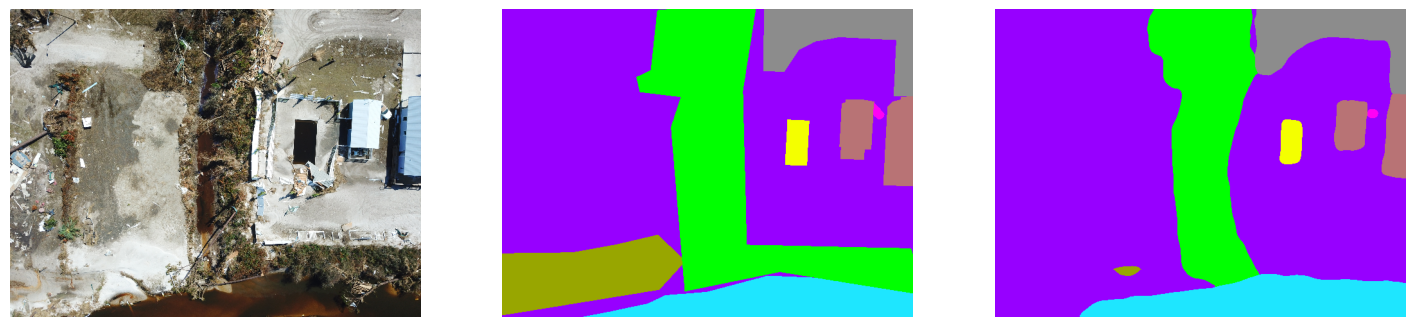

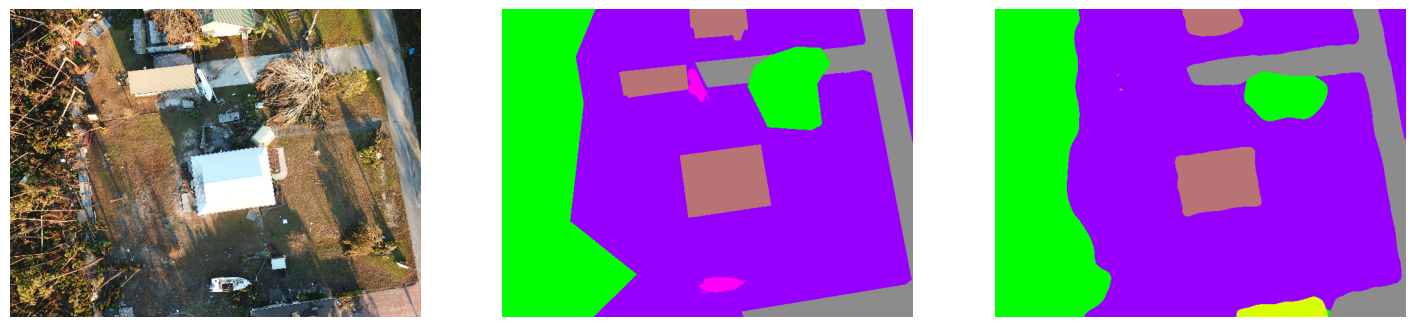

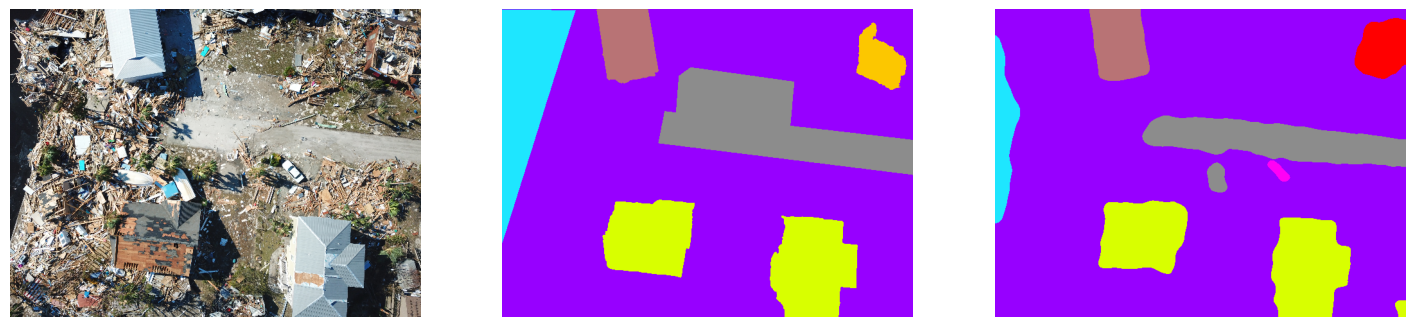

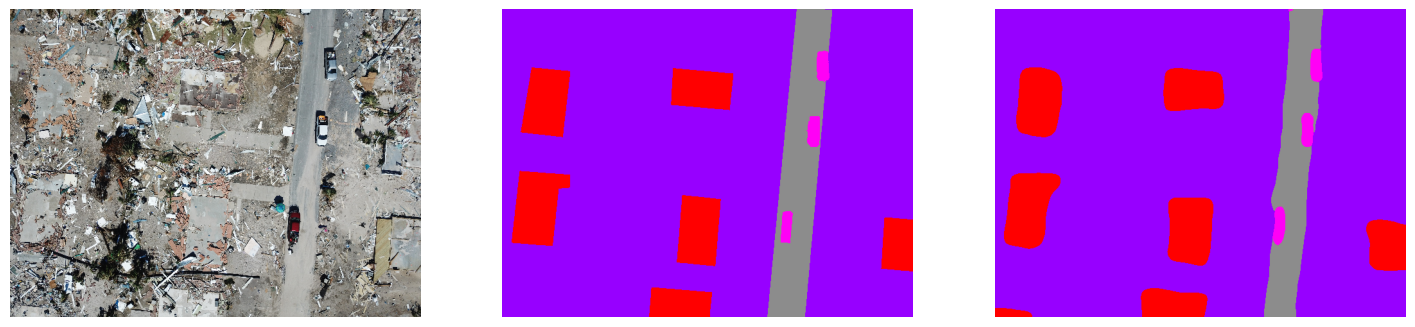

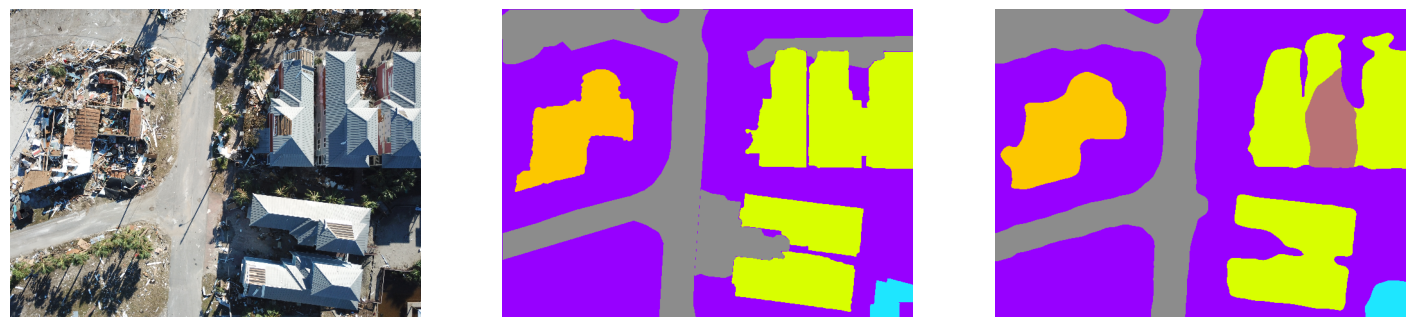

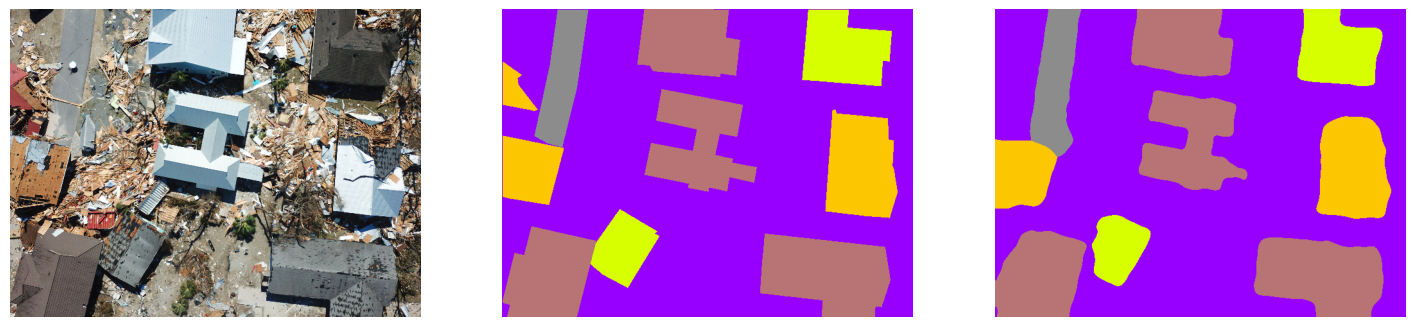

In [87]:

imglist = [15783, 13205, 11236, 10844, 12272, 11669]


base_org_img_path = '/kaggle/input/rescuenet-test/test/test-org-img/{img_id}.jpg'
base_label_img_path = '/kaggle/input/rescuenet-test/test/test-label-img/{img_id}_lab.png'

for img_id in imglist:
   
    org_img_path = base_org_img_path.format(img_id=img_id)
    label_img_path = base_label_img_path.format(img_id=img_id)

    visualize_one(org_img_path, label_img_path)

# ****Test****

In [88]:
import segmentation_models_pytorch as smp
import torch
import numpy as np
from tqdm import tqdm
import segmentation_models_pytorch.utils


def test_one_epoch(model, test_loader, DEVICE=DEVICE):
    model.eval()
    with torch.no_grad():
        IoU_List = np.zeros(shape=12, dtype='float32')
        Fscore_List = np.zeros(shape=12, dtype='float32')
        
        iou_metric = smp.utils.metrics.IoU()  
        fscore_metric = smp.utils.metrics.Fscore()

        loop = tqdm(test_loader)
        
        for batch_index, (imgs, masks) in enumerate(loop):
            preds = model(imgs.to(DEVICE))  # shape [8,12,h,w]
            
            masks = masks.permute(1, 0, 2, 3)  # shape [12,8,h,w]
            preds_argmax = torch.argmax(preds, axis=1)  # shape [8,h,w]
            
            preds_stacked = (preds_argmax == 0).unsqueeze(0)  # shape [1,8,h,w]
            for i in range(1, 12):
                preds_stacked = torch.cat((preds_stacked, (preds_argmax == i).unsqueeze(0)))
                
            preds_stacked = preds_stacked.to(dtype=torch.int8)  # shape [12,8,h,w]

            for i in range(12):
                preds_layer = preds_stacked[i]  # shape [8,h,w]
                masks_layer = masks[i]  # shape [8,h,w]
                
                preds_layer = preds_layer.flatten()  # shape [8*h*w]
                masks_layer = masks_layer.flatten()  # shape [8*h*w]
                
                layer_iou = iou_metric(preds_layer.cpu(), masks_layer)  # one float number
                layer_fscore = fscore_metric(preds_layer.cpu(), masks_layer)  # one float number
                
                IoU_List[i] += layer_iou
                Fscore_List[i] += layer_fscore
                
            loop.set_postfix(
                background=IoU_List[0]/(batch_index+1),
                debris=IoU_List[1]/(batch_index+1),
                water=IoU_List[2]/(batch_index+1),
                building_no_damage=IoU_List[3]/(batch_index+1),
                building_minor_damage=IoU_List[4]/(batch_index+1),
                building_major_damage=IoU_List[5]/(batch_index+1),
                building_total_destruction=IoU_List[6]/(batch_index+1),
                vehicle=IoU_List[7]/(batch_index+1),
                road=IoU_List[8]/(batch_index+1),
                pool=IoU_List[9]/(batch_index+1),
                tree=IoU_List[10]/(batch_index+1),
                sand=IoU_List[11]/(batch_index+1),
                mean_IoU=IoU_List[1:12].mean()/(batch_index+1),
                mean_Fscore=Fscore_List[1:12].mean()/(batch_index+1)
            )

        IoU_List = IoU_List / len(test_loader)
        Fscore_List = Fscore_List / len(test_loader)

        print("background IoU = {}".format(IoU_List[0]))
        print("debris IoU = {}".format(IoU_List[1]))
        print("water IoU = {}".format(IoU_List[2]))
        print("building-no-damage IoU = {}".format(IoU_List[3]))
        print("building-minor-damage IoU = {}".format(IoU_List[4]))
        print("building-major-damage IoU = {}".format(IoU_List[5]))
        print("building-total-destruction IoU = {}".format(IoU_List[6]))
        print("vehicle IoU = {}".format(IoU_List[7]))
        print("road IoU = {}".format(IoU_List[8]))
        print("tree IoU = {}".format(IoU_List[9]))
        print("pool IoU = {}".format(IoU_List[10]))
        print("sand IoU = {}".format(IoU_List[11]))
        


        print("Test got mean IoU {}".format(IoU_List[1:12].mean()))
        print("Test got mean F1_score {}".format(Fscore_List[1:12].mean()))


In [89]:
test_one_epoch(model, test_loader)

100%|██████████| 112/112 [01:29<00:00,  1.25it/s, background=0.444, building_major_damage=0.624, building_minor_damage=0.475, building_no_damage=0.617, building_total_destruction=0.687, debris=0.661, mean_Fscore=0.768, mean_IoU=0.689, pool=0.752, road=0.756, sand=0.735, tree=0.916, vehicle=0.629, water=0.731]

background IoU = 0.4441533386707306
debris IoU = 0.6605400443077087
water IoU = 0.7307471632957458
building-no-damage IoU = 0.6169320344924927
building-minor-damage IoU = 0.4750501215457916
building-major-damage IoU = 0.6241880059242249
building-total-destruction IoU = 0.686517596244812
vehicle IoU = 0.6290574073791504
road IoU = 0.7559973001480103
tree IoU = 0.7521754503250122
pool IoU = 0.9155904054641724
sand IoU = 0.7346354722976685
Test got mean IoU 0.6892209649085999
Test got mean F1_score 0.7683597207069397


## metrics: FLOPS
MACs and FLOPs for each layer:
formula is output_image_size * kernel shape * output_channels
* MACs: I × O
* FLOPs: 2 × (I × O) (since each MAC counts as two FLOPs)
* fps = (total_frames / batch_size) / total_inference_time

In [90]:
! pip install torchprofile 

In [91]:
from torchprofile import profile_macs
sample_data = torch.randn(1, 3,480, 640, ).cuda()

macs = profile_macs(model,sample_data)
print(f'The macs is {macs}')
print(f'The FLOPs is {macs*2}')

The macs is 65266122912
The FLOPs is 130532245824


/opt/conda/lib/python3.10/site-packages/torchprofile/profile.py:22: UserWarning: No handlers found: "aten::pow". Skipped.
  warnings.warn('No handlers found: "{}". Skipped.'.format(
/opt/conda/lib/python3.10/site-packages/torchprofile/profile.py:22: UserWarning: No handlers found: "aten::sqrt". Skipped.
  warnings.warn('No handlers found: "{}". Skipped.'.format(
/opt/conda/lib/python3.10/site-packages/torchprofile/profile.py:22: UserWarning: No handlers found: "aten::unsqueeze". Skipped.
  warnings.warn('No handlers found: "{}". Skipped.'.format(
/opt/conda/lib/python3.10/site-packages/torchprofile/profile.py:22: UserWarning: No handlers found: "aten::permute". Skipped.
  warnings.warn('No handlers found: "{}". Skipped.'.format(
/opt/conda/lib/python3.10/site-packages/torchprofile/profile.py:22: UserWarning: No handlers found: "aten::gelu". Skipped.
  warnings.warn('No handlers found: "{}". Skipped.'.format(


In [92]:
import time

def measure_latency(model, input_data):
    start_time = time.time()
    # For GPU (PyTorch)
    start_event = torch.cuda.Event(enable_timing=True)
    end_event = torch.cuda.Event(enable_timing=True)

    start_event.record()
    output = model(input_data)
    end_event.record()
    torch.cuda.synchronize()

    end_time = time.time()
    inference_time = end_time - start_time
    return inference_time


measure_latency(model, sample_data)

0.03910517692565918

In [ ]:
# Timing the model inference
start_time = time.time()
batch_sample_data = torch.randn(8, 3,480, 640, ).cuda()

# For GPU (PyTorch)
start_event = torch.cuda.Event(enable_timing=True)
end_event = torch.cuda.Event(enable_timing=True)

start_event.record()
output = model(batch_sample_data)
end_event.record()
torch.cuda.synchronize()

end_time = time.time()
inference_time = end_time - start_time

# Calculate FPS
batch_size = len(batch_sample_data)  # or whatever your batch size is
print(f"batch_size {batch_size}")
fps = batch_size / inference_time

print(f"Inference time: {inference_time:.4f} seconds")
print(f"FPS: {fps:.2f}")

In [93]:
import time
import torch

def calculate_fps_latency(model, input_size, num_samples=100):
    model.eval()
    device = next(model.parameters()).device  # Get the device of the model (cuda or cpu)
    start_time = time.time()
    with torch.no_grad():
        for _ in range(num_samples):
            input_data = torch.rand(input_size).to(device)  # Move input data to the correct device
            output = model(input_data)
    end_time = time.time()
    
    total_time = end_time - start_time
    latency = (total_time / num_samples) * 1000  # in milliseconds
    fps = 1 / (total_time / num_samples)
    
    return fps, latency

input_size = (1, 3, 480, 640)
fps, latency = calculate_fps_latency(model, input_size)
print(f"FPS: {fps}")
print(f"Latency: {latency} ms")

FPS: 28.57624835906281
Latency: 34.994096755981445 ms
